In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

### Preparing the data set

There will be several data sets we therefore define abstract interface an implement concrete classes that derive the interface below.

In [2]:
class Dataset(ABC):
        
    @abstractmethod
    def get_train_x(self):
        """ Retrieve the input data of the training """
        pass
    
    @abstractmethod
    def get_train_y(self):
        """ Retrieve the output data of the training """
        pass
    
    @abstractmethod
    def get_test_x(self):
        """ Retrieve the input data of the test """
        pass
    
    @abstractmethod
    def get_test_y(self):
        """ Retrieve the output data of the test """
        pass

In [3]:
class XORDataset(Dataset):
    
    _x = None
    _y = None
    
    def __init__(self):
        self._x = np.array([[0,0],[1, 0],[0,1],[1,1]])
        self._y = np.array([[0],[1],[1],[0]])
    
    def get_train_x(self):
        return self._x
    
    def get_train_y(self):
        return self._y
    
    def get_test_x(self):
        return self._x
    
    def get_test_y(self):
        return self._y

### Operations of a neural network

Every neural network consists of serveral operations which gets executed during a forward and backward pass

In [4]:
class Operation(ABC):
        
    @abstractmethod
    def forward(self, data):
        """ Forward pass of the operation. Process the input data.
        
        Parameters
        ----------
        data : ndarray
            Data from the last layer
        
        Returns
        -------
        result : ndarray
            The result of processing the input data
        """
        pass
    
    @abstractmethod
    def backward(self, gradient_data):
        """ Backward pass of the operation. The gradient data is uses 
        to compute the changes of weights and the partial gradient of 
        the this layer.
        
        Parameters
        ----------
        gradient_data : ndarray
            Gradient data from the previous layer during the backward pass
        
        Returns
        -------
        result : ndarray
            The partial gradient of the this layer with respect to the incoming gradient_data
        """
        pass

### TODO implement the different operations of a network

In [5]:
class BiasOperation(Operation):
    """ Bias operation in the network """
    
    def forward(self, data):
        return data
    
    def backward(self, gradient_data):
        return gradient_data

In [6]:
class SigmoidOperation(Operation):
    """ Sigmoid function in the network """
    
    def forward(self, data):
        return data
    
    def backward(self, gradient_data):
        return gradient_data

In [7]:
class LossOperation(Operation):
    """ Loss function in the network """    
    _y = None
    
    def set_y(self, y):
        """ Store the correct y value for later comparison """
        self._y = y
    
    def forward(self, data):
        return data
    
    def backward(self, gradient_data):
        return gradient_data

In [8]:
class InnerProductOperation(Operation):
    """ Inner Product, Fully Connected or Dense operation in the network """
    _learn_rate = 0.1
    _weights = None
    
    def __init__(self, input_units, hidden_units):
        self._weights = np.random.uniform(low = -1, high = 1, size = (input_units, hidden_units))
    
    def set_learn_rate(self, learn_rate):
        """ Change the learn rate """
        self._learn_rate = learn_rate
    
    def forward(self, data):
        return data
    
    def backward(self, gradient_data):
        return gradient_data

### Setup the neural network 

Using the operations we can now build our own neural network

In [9]:
class Network(ABC):
    
    _ops = []
    _train_errors = []
    _test_accuracies = []
    
    def get_test_accuracies(self):
        return self._test_accuracies
    
    def get_train_errors(self):
        return self._train_errors
    
    def predict(self,data):
        return self.forwardPass(data, len(self._ops)-1)
    
    def forwardPass(self,data, layers):
        result = data
        for op in range(0,layers):     
            result = self._ops[op].forward(result)
        return (result)
        
    def backwardPass(self, data, layers):
        result = data
        for op in range(len(self._ops)-1, len(self._ops) - layers , -1):
            result = self._ops[op].backward(result)
        return result
    
    @abstractmethod
    def train(self, dataset, epochs, learn_rate, error_output_every):
        """ Train the neural network with the data set several epochs.
        Compute the train error and test accurarcy after some iterations.
        
        Parameters
        ----------
        dataset : ndarray
            Data from the last layer
        epochs : int
            Number of epochs to be trained
        learn_rate : float
            Learn rated to be used to changing the weights of the network
        error_output_every : int
            After how many iterations should the train error and test accurarcy be calculated
        """
        pass

In [10]:
class LogicGateNetwork(Network):
    
    def __init__(self, input_units, output_units, hidden_units):
        self._ops = []
        self._ops.append(BiasOperation())
        self._ops.append(InnerProductOperation(input_units +1, hidden_units))
        self._ops.append(SigmoidOperation())
        self._ops.append(BiasOperation())
        self._ops.append(InnerProductOperation(hidden_units +1, output_units))
        self._ops.append(SigmoidOperation())
        self._ops.append(LossOperation())
        print('Setup XOR Network')
        
    def train(self, dataset, epochs, learn_rate, error_output_every):
        print('Start training of the XOR network ...')
        
        #clear old train errors and test accuracies
        self._train_errors = []
        self._test_accuracies = []
        
        # fix learn rate for all layers
        for op in self._ops:
            if type(op) == InnerProductOperation:
                op.set_learn_rate(learn_rate)
                
        # get the last layer (loss layer)
        last_layer = self._ops[len(self._ops)-1]
       
        # get the train and test data
        train_x = dataset.get_train_x()
        train_y = dataset.get_train_y()
        test_x = dataset.get_test_x()
        test_y = dataset.get_test_y()
        
        # train the network
        for e in range(0, epochs+1):
            
            # forward propagation
            hypothese = self.predict(train_x)
            
            # place the target data in the loss layer
            last_layer.set_y(train_y)
            
            # backward propagate and change the weights
            self.backwardPass(hypothese, len(self._ops))
            
            # print the train and test error rate after 100 epochs
            if (e % error_output_every == 0):
                
                # compute train error with the train data
                error = last_layer.forward(hypothese).sum()/train_x.shape[0]
                self._train_errors.append(error)
                
                # compute test accuracy with the test data
                accuracy = (np.where(self.predict(test_x) > 0.5,1,0) == test_y).all(axis=1).sum() / test_x.shape[0] * 100
                self._test_accuracies.append(accuracy)
                print('Epoche ',e, 'with error:', error, 'and accuracy:', accuracy)

### Use the LogicGateNetwork and XORDataset to train the network for solving the XOR problem
Change the number of hidden neurons in the network and learn rate to converge faster

In [11]:
training_iterations = 5000
error_output_every = 1000
learn_rate = 0.7
hidden_units = 5
np.random.seed(5)

dataSet = XORDataset()
network = LogicGateNetwork(dataSet.get_train_x().shape[1], dataSet.get_train_x().shape[1], hidden_units)

network.train(dataSet, training_iterations, learn_rate, error_output_every)
print('final prediction: \n', network.predict(dataSet.get_test_x()))
accuracies = network.get_test_accuracies()
print('overall accuracy = ', accuracies[len(network.get_test_accuracies())-1])

Setup XOR Network
Start training of the XOR network ...
Epoche  0 with error: 1.0 and accuracy: 25.0
Epoche  1000 with error: 1.0 and accuracy: 25.0
Epoche  2000 with error: 1.0 and accuracy: 25.0
Epoche  3000 with error: 1.0 and accuracy: 25.0
Epoche  4000 with error: 1.0 and accuracy: 25.0
Epoche  5000 with error: 1.0 and accuracy: 25.0
final prediction: 
 [[0 0]
 [1 0]
 [0 1]
 [1 1]]
overall accuracy =  25.0


(0.0, 5000.0, 0.0, 100.0)

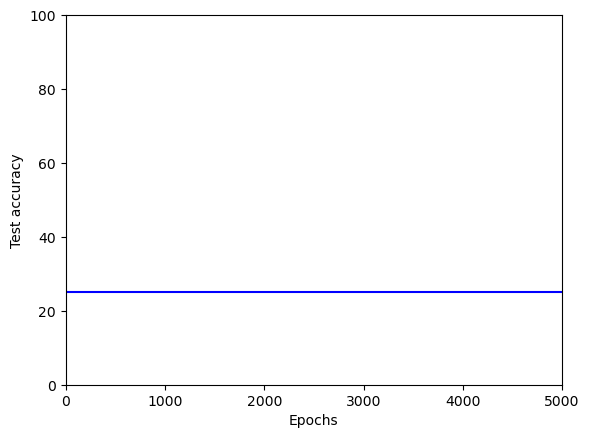

In [12]:
plt.plot(np.linspace(0, training_iterations, len(accuracies)), accuracies, 'b', label ='xor data')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.axis([0, training_iterations, 0, 100 ])